# DJI Price Direction Prediction though Natural Language Processing

----
*By Ethan Koh,  29 June 2020*

# Background

The goal of almost every professional or casual financial investor is to better predict stock market prices and reap positive gains. Founded in 1885, the Dow Jones Industrial Average (DJIA) is a stock market index that measures the stock performance of 30 large companies listed on stock exchanges in the United States. It consisted of companies such as 3M, Apple Inc, etc. 

Many factors can affect stock prices, ranging from economic landscape, companies acquisitions, to political instability etc. It is almost impossible to pin point specific features that contribute to stock prices movement. This project is not simply about predicting the stock market movement, but also to understand how everyday news might contribute to stock prices movement, if any.

# Problem Statement 

Have you thought of putting some savings into the stock market thinking it's sufficient to watch everyday world news to roughly know the stock prices movement? Using the top 25 up voted world news title from [Reddit](https://www.redditinc.com/) users under the subreddit [r/worldnews](https://www.reddit.com/r/worldnews/), we are going to explore and build a model in predicting whether Dow Jones Index(DJI) will increase,decrease or remain the same for a given day. We are having a binary classification as our target variable where DJI labels "1" if the price increase or stays the same, and "0" when the price decreases from the previous trading day. We will be using accuracy as our scoring metric.

# Dataset

Dataset is obtained from Kaggle provided by Sun.
The first column is "Date", the second is "Label", and the following ones are news headlines ranging from "Top1" to "Top25". News titles are scrapped from reddit.

Source: Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. Retrieved [31 May 2020] from https://www.kaggle.com/aaron7sun/stocknews.

# Executive Summary

Using top 25 world news title from reddit alone may not be a sufficient corpus to train a good model for predicting whether price will go up or down for DJIA. The test score is worse than the baseline model(score:0.5424) despite running a few models and vectorizers. The best model, though below baseline model, was using 3 ngram CountVectorizer with Logisitic Regression with validation accuracy score of 0.5150. Best training Accuracy score during GridSearch was 0.6253. However, cross validation mean score is 0.5153. Overall there is still underfit since validation score is not better than baseline and training score.

Sentimental Analysis using TextBlob was then used to give sentiment scores to the news to model instead of relying on just vectorizing tools from Natural Language Processing. However, the score was still poor below baseline model. Looking into the sentimental score EDA suggest many were give neutral sentiment of score 0, unable to facilitate in modeling.

Though the classification model was not successful, a glimpse into the EDA suggests that everyday news might have little to contribute to the DJIA pricing movement. Hence, this project concludes that watching daily everyday news alone might not be sufficient to decide whether prices are trending upwards or downwards at any given day. Thus, more precaution and work have to be done while trading in stock market. One should not simply trade based on watching daily world news.

# Content

- [Import Libraries](#Import-Libraries)
- [Load CSV](#Load-CSV)
- [Macro Analysis](#Macro-Analysis)
- [Split data into training and testing sets](#Split-data-into-training-and-testing-sets)
- [Baseline Model](#Baseline-Model)
- [Preprocessing](#Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Fit Logistic Model with CountVectorizer 1-gram](#Fit-Logistic-Model-with-CountVectorizer-1-gram)
- [Fit Logistic Model with CountVectorizer 2-gram](#Fit-Logistic-Model-with-CountVectorizer-2-gram)
- [Fit Logistic Model with CountVectorizer 3-gram](#Fit-Logistic-Model-with-CountVectorizer-3-gram)
- [Fit Logistic Model with Tfidf Vectorizer 2-gram](#Fit-Logistic-Model-with-Tfidf-Vectorizer-2-gram)
- [Fit Random Forest with CountVectorizer 2-gram](#Fit-Random-Forest-with-CountVectorizer-2-gram)
- [Fit Random Forest with Tfidf Vectorizer](#Fit-Random-Forest-with-Tfidf-Vectorizer)
- [Fit Naive Bayes with CountVectorizer 2-gram](#Fit-Naive-Bayes-with-CountVectorizer-2-gram)
- [Sentimental Score Feature Engineering](#Sentimental-Score-Feature-Engineering)
- [Fit Logistic Regression for the Sentiment Score](#Fit-Logistic-Regression-for-the-Sentiment-Score)
- [Best Model: Logistic Regression with CountVectorizer 3-gram](#Best-Model:-Logistic-Regression-with-CountVectorizer-3-gram)
- [Conclusion](#Conclusion)
- [Limitations and Recommendation](#Limitations-and-Recommendation)

# Import Libraries

In [1]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup  
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import collections
import itertools
import pandas as pd
import re
import math
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2,venn2_circles
from textblob import TextBlob

# Load CSV

In [2]:
# Read csv
data = pd.read_csv('./datasets/Combined_News_DJIA.csv')

In [3]:
# Display data
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [4]:
# Display dataframe shape
data.shape
# 27 columns: 1 target, 26 features
# 1989 observations

(1989, 27)

# Macro Analysis

### Check for null

In [5]:
# check for nulls
data.isnull().sum()
# Only 3 features with missing rows

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [6]:
# See missing data in Top23
data[data['Top23'].isnull()]

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
277,2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN


In [7]:
# See missing data in Top24
data[data['Top24'].isnull()]

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
277,2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
348,2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...",...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
681,2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


In [8]:
# See missing data in Top25
data[data['Top25'].isnull()]

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
277,2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
348,2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...",...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
681,2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


In [9]:
# Convert NaN to blanks
data['Top23'].fillna('',inplace=True)
data['Top24'].fillna('',inplace=True)
data['Top25'].fillna('',inplace=True)
# check for nulls again
data.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    0
Top24    0
Top25    0
dtype: int64

### Check for duplicate

In [10]:
# Check for Duplicated Title and investigate how many
for i in data.columns:
    print(i)
    # Find a duplicate rows
    print(data[data.duplicated([i])])
    
# not many duplicate cells. less than 10. Suspect is due to pinned post

Date
Empty DataFrame
Columns: [Date, Label, Top1, Top2, Top3, Top4, Top5, Top6, Top7, Top8, Top9, Top10, Top11, Top12, Top13, Top14, Top15, Top16, Top17, Top18, Top19, Top20, Top21, Top22, Top23, Top24, Top25]
Index: []

[0 rows x 27 columns]
Label
            Date  Label                                               Top1  \
2     2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3     2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4     2008-08-14      1  b'All the experts admit that we should legalis...   
5     2008-08-15      1  b"Mom of missing gay man: Too bad he's not a 2...   
6     2008-08-18      0  b'In an Afghan prison, the majority of female ...   
...          ...    ...                                                ...   
1984  2016-06-27      0  Barclays and RBS shares suspended from trading...   
1985  2016-06-28      1  2,500 Scientists To Australia: If You Want To ...   
1986  2016-06-29      1                   Explosi

# Split to X and y

In [11]:
# select x variables
columns = data.columns[(data.columns != 'Date') & (data.columns != 'Label')]
columns

Index(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9',
       'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17',
       'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'],
      dtype='object')

In [12]:
# Split daata into features X and target y
y = data['Label']
X = data[columns]

In [13]:
# Create a combine feature for EDA later
X['Combined'] = X[columns].apply(lambda x: ' '.join(x), axis = 1)

/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Display top 2 rows of X
X.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined
0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou..."
1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...


In [15]:
# Display top 5 rows of y
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Label, dtype: int64

In [16]:
# Display X dataframe shape
X.shape

(1989, 26)

In [17]:
# Display y dataframe shape
y.shape

(1989,)

In [18]:
# Check datatype for X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Top1      1989 non-null   object
 1   Top2      1989 non-null   object
 2   Top3      1989 non-null   object
 3   Top4      1989 non-null   object
 4   Top5      1989 non-null   object
 5   Top6      1989 non-null   object
 6   Top7      1989 non-null   object
 7   Top8      1989 non-null   object
 8   Top9      1989 non-null   object
 9   Top10     1989 non-null   object
 10  Top11     1989 non-null   object
 11  Top12     1989 non-null   object
 12  Top13     1989 non-null   object
 13  Top14     1989 non-null   object
 14  Top15     1989 non-null   object
 15  Top16     1989 non-null   object
 16  Top17     1989 non-null   object
 17  Top18     1989 non-null   object
 18  Top19     1989 non-null   object
 19  Top20     1989 non-null   object
 20  Top21     1989 non-null   object
 21  Top22     1989

In [19]:
# Display first date and last date of data
print("First date: "+ data['Date'].min())
print("Last date: "+ data['Date'].max())

First date: 2008-08-08
Last date: 2016-07-01


In [20]:
# Check date
data['Date'].head(15)

0     2008-08-08
1     2008-08-11
2     2008-08-12
3     2008-08-13
4     2008-08-14
5     2008-08-15
6     2008-08-18
7     2008-08-19
8     2008-08-20
9     2008-08-21
10    2008-08-22
11    2008-08-25
12    2008-08-26
13    2008-08-27
14    2008-08-28
Name: Date, dtype: object

Notice that the observations data is not everyday. 8 August 2008 falls on a Friday. 
11 to 15 August 2008 falls on weekday. Same for 18 to 22 August 2008. This means that there is no stock trading on weekends. [The New York Stock Exchange (NYSE)](https://www.investors.com/research/stock-market-holidays/) is also closed on public holidays and special occassions such as mourning subject to announcement.

# Split data into training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.2) 

In [22]:
X_test.reset_index(inplace=True,drop=True)

# Baseline Model

In [23]:
y_train.value_counts(normalize=True)

1    0.542426
0    0.457574
Name: Label, dtype: float64

# Preprocessing

In [24]:
# print stopwords from wordcloud library
print("There are "+ str(len(STOPWORDS)) + " stopwords.\n")
print(STOPWORDS)

There are 192 stopwords.

{"it's", 'hers', 'until', 'into', 'by', 'get', "we'll", 'both', 'during', 'off', 'she', "who's", 'our', 'who', 'is', 'and', "they'd", 'in', "you'd", 'his', 'nor', 'your', 'cannot', "why's", 'each', "i'd", 'not', 'because', "we'd", 'be', 'there', "i'm", 'whom', 'of', 'a', 'too', 'own', 'however', 'against', 'only', 'further', "we've", "hasn't", 'their', "that's", "doesn't", "don't", 'were', 'me', "she'd", 'ever', 'than', 'more', 'any', 'for', 'i', "where's", 'k', 'has', "can't", 'its', "she'll", 'between', 'did', 'themselves', 'very', 'www', 'http', "wasn't", 'her', 'yourselves', 'up', 'an', 'does', 'since', 'com', 'my', 'therefore', 'else', 'then', 'if', 'over', "haven't", "he'll", 'but', 'below', 'out', 'down', 'himself', "shouldn't", 'through', 'when', 'should', 'herself', "what's", "hadn't", 'do', "shan't", 'from', "weren't", 'how', "she's", "i'll", 'most', 'at', 'again', 'to', 'once', 'just', "when's", 'yours', "here's", 'had', 'the', "wouldn't", 'itself',

In [25]:
# Print stopwords from nltk library
print("There are "+ str(len(stopwords.words('english'))) + " stopwords.\n")
print(stopwords.words('english'))

There are 179 stopwords.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [26]:
# Function to remove stopwords
def remove_stopwords(series,stopwords):
    new=[]
    combine=series.split()
    for i in combine:
        if i in stopwords:
            continue;
        else:
            new.append(i)
    return ' '.join(new)

In [27]:
# combine nltk, wordcloud's stopwords 
# excluding 'year' and 'say' which is discovered from later and put back here to be removed
stopwords_combined = list(set().union(STOPWORDS,stopwords.words('english'))-set(['not']))
stopwords_combined.extend(['year','say'])
print("There are "+ str(len(stopwords_combined)) + " stopwords.\n")
print(stopwords_combined)

There are 228 stopwords.

['y', "it's", 'won', 'hers', 'until', 'into', 'by', 'get', 'isn', "we'll", 'both', 'during', 'mightn', 'off', 'she', "who's", "needn't", 'our', "should've", "mightn't", 'who', 'is', 'll', 'and', "they'd", 'in', "you'd", 'his', 'nor', 'your', 't', 'weren', 'cannot', "why's", 'didn', 'each', "i'd", 'couldn', 'because', "we'd", 'be', 'there', "i'm", 'whom', 'of', 'a', 'too', 'own', 'however', 'against', 'only', 'further', "we've", "hasn't", 'their', "that's", "doesn't", "don't", 'were', 'me', "she'd", 'ever', 'than', 'more', 'any', 'for', 'i', "where's", 'needn', 'k', 'has', 're', "can't", 'ma', 'o', 'its', "she'll", 'between', 'did', 'themselves', 'very', 'www', 'http', "wasn't", 'her', 'yourselves', 'up', 'an', 'does', 'since', 'com', 'my', 'therefore', 'else', 'haven', 'then', 'if', 'over', "haven't", "he'll", 'but', 'below', 'out', 'down', 'himself', "shouldn't", 'through', 'when', 'should', 'wouldn', 'herself', "what's", 'don', "hadn't", 'do', "shan't", 'fro

In [28]:
def titles_combine(titles):
    # Function to convert a raw titles to a string of cleaned words
    # The input is a single string (a raw title of a news), and 
    # the output is a single string (a preprocessed title)
    
    # 1. Remove HTML, if any
    titles = BeautifulSoup(titles).get_text()
    
     # 2. Remove b' starting
    titles = re.sub('(^b\')|(^b\")',' ',''.join(titles))
    
    # 3. Remove stopwords first before removing non-letters
    # Temporary split the sentence into words
    words_split = titles.split()
    temp_split = [w for w in words_split if not w in stopwords_combined] 
    titles = ' '.join(temp_split)

    # 4. Remove non-letters and numbers except full stop
    # A-z didn't remove \ properly so used A-Za-z instead
    titles = ''.join(re.sub("[^A-Za-z. \t]",' ', titles))

    # 5. Convert to lower case, split into individual words
    titles = titles.lower()
    
    # 6. Tokenize: Split the sentence into words
    words_list = nltk.word_tokenize(titles)
    
    # 7. Lemmatize list of words and join
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in words_list])
    
    # 8. Remove full stop only
    # Convert example U.S. to U.S 
    cleaned_titles = re.sub('\.\s+',' ',''.join(lemmatized_output))
    cleaned_titles = re.sub('\s+\.',' ',''.join(cleaned_titles))
    
    return (cleaned_titles)

In [29]:
# Function to loop each row to cleanup
def data_cleanup(df,cols):
    df_new = pd.DataFrame()
    for col in tqdm(cols):
        for i in range(len(df[col])):
            df_new.loc[i,col] = titles_combine(df.loc[i,col])
                
    return df_new

In [30]:
# Apply cleanup function to train and test data
# Create a combine feature
X_train['Combined_new'] = data_cleanup(X_train,columns)[columns].apply(lambda x: ' '.join(x), axis = 1)
X_test['Combined_new'] = data_cleanup(X_test,columns)[columns].apply(lambda x: ' '.join(x), axis = 1)

/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
# Display one of the cleaned combine feature
X_train['Combined_new'][0]

'georgia down two russian warplane country move brink war breaking musharraf impeached  russia today column troop roll south ossetia footage fighting youtube russian tank moving towards capital south ossetia reportedly completely destroyed georgian artillery fire afghan child raped impunity u.n official say sick three old raped nothing russian tank entered south ossetia whilst georgia shoot two russian jet  breaking georgia invades south ossetia russia warned intervene so s side the enemy combatent trial nothing sham salim haman sentenced year kept longer anyway feel it  georgian troop retreat s osettain capital presumably leaving several hundred people killed  video did u.s prep georgia war russia rice give green light israel attack iran say u.s veto israeli military ops announcing class action lawsuit behalf american public against fbi so russia georgia war nyt s top story opening ceremony olympics what fucking disgrace yet proof decline journalism  china tell bush stay country affai

In [32]:
# Compare with the original title before cleaning
X_train['Combined'][0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\'

# Exploratory Data Analysis

In [33]:
# Display first date and last date of train set
print("First date of Train set: "+ data.loc[0,'Date'])
print("Last date of Train set: "+ data.loc[X_train.shape[0],'Date'])

# Display first date and last date of test set
print("First date of Test set: "+ data.loc[X_train.shape[0]+1,'Date'])
print("Last date of Test set: "+ data['Date'].max())

First date of Train set: 2008-08-08
Last date of Train set: 2014-12-03
First date of Test set: 2014-12-04
Last date of Test set: 2016-07-01


In [34]:
# Display number of observations in Train set
print("Number of observations in Train set: "+ str(X_train.shape[0]))

# Display number of observations in Test set
print("Number of observations in Train set: "+ str(X_test.shape[0]))

Number of observations in Train set: 1591
Number of observations in Train set: 398


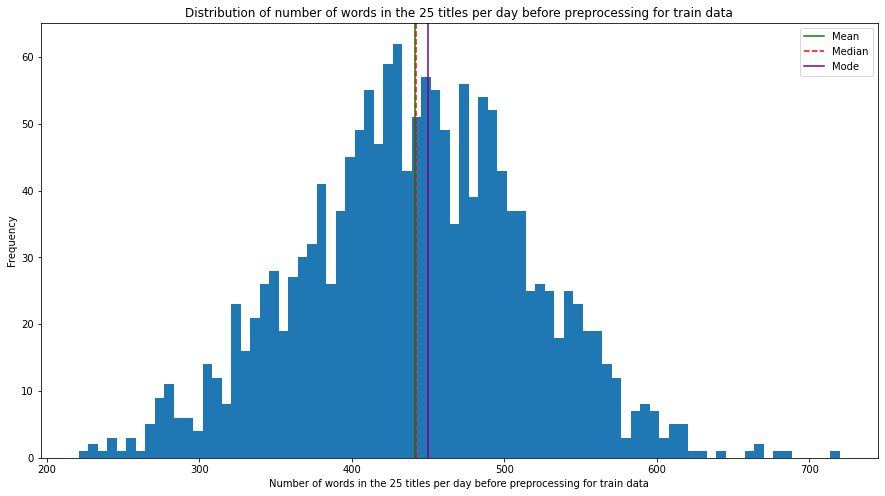

In [35]:
# Distribution of Number of words in the 25 titles per day for train data

# Split into words to be counted
X_train_count = list(map(lambda x: len(x.split()), X_train['Combined']))
count_df = pd.DataFrame({'counts': X_train_count})
# Put word counts as x
x=count_df.counts

# Configure plot size
plt.figure(figsize=(15,8))
# Plot histogram
count_df.counts.plot.hist(bins = 80);
# add mean, median, model to plot
mean=x.mean()
median=x.median()
mode=pd.DataFrame(x.mode())[0][0]
plt.xlabel("Number of words in the 25 titles per day before preprocessing for train data")
plt.axvline(mean, color='green')
plt.axvline(median, color='red',linestyle= '--')
plt.axvline(mode, color='purple')
# Add title
plt.title("Distribution of number of words in the 25 titles per day before preprocessing for train data")
# Add legend
plt.legend({'Mean':mean,'Median':median,'Mode':mode});

In [36]:
# Print total number words
print('Before Preprocessing: ')
print('                            ')
print ("There are {} words in total from train set.".format(sum(list(map(lambda x: len(x.split()), X_train['Combined'])))))
print ("There are {} words in total from test set.".format(sum(list(map(lambda x: len(x.split()), X_test['Combined'])))))
print('                            ')
print('After Preprocessing: ')
print('                            ')
print ("There are {} words in total from train set.".format(sum(list(map(lambda x: len(x.split()), X_train['Combined_new'])))))
print ("There are {} words in total from test set.".format(sum(list(map(lambda x: len(x.split()), X_test['Combined_new'])))))

Before Preprocessing: 
                            
There are 702193 words in total from train set.
There are 177957 words in total from test set.
                            
After Preprocessing: 
                            
There are 494133 words in total from train set.
There are 126386 words in total from test set.


In [37]:
# Print total number of unique words 
plain_cvec = CountVectorizer()
print('Before Preprocessing: ')
print('                            ')
print ("There are {} unique words in total from train set.".format(plain_cvec.fit_transform(X_train['Combined']).shape[1]))
print ("There are {} unique words in total from test set.".format(plain_cvec.fit_transform(X_test['Combined']).shape[1]))
print('                            ')
print('After Preprocessing: ')
print('                            ')
print ("There are {} unique words in total from train set.".format(plain_cvec.fit_transform(X_train['Combined_new']).shape[1]))
print ("There are {} unique words in total from test set.".format(plain_cvec.fit_transform(X_test['Combined_new']).shape[1]))

Before Preprocessing: 
                            
There are 31514 unique words in total from train set.
There are 16509 unique words in total from test set.
                            
After Preprocessing: 
                            
There are 26319 unique words in total from train set.
There are 13746 unique words in total from test set.


In [38]:
# Create dataframe to temporary combine titles,labels and counts
# To look at most common words
X_train_count = list(map(lambda x: len(x.split()), X_train['Combined_new']))
train_df_count = pd.concat([X_train['Combined_new'],y_train,pd.Series(X_train_count)],axis=1)
train_df_count.columns=['Combined_new', 'Label', "Counts"]
train_df_count.head()

# To look at the words for both classes: 1 and 0 after preprocessing

# Split into class 1 and 0
price_up = train_df_count[train_df_count['Label']==1]
price_down= train_df_count[train_df_count['Label']==0]

# Do a simple preprocesing split the words using .split
words_up= [post.split() for post in price_up['Combined_new']]
words_down= [post.split() for post in price_down['Combined_new']]


# Flatten your list, so that all words across the posts are in one list
all_words_up = list(itertools.chain(*words_up))
all_words_down= list(itertools.chain(*words_down))

# To get the count of how many times each word appears in the train set
# Use built-in Python library 'collections'
counts_up = collections.Counter(all_words_up)
counts_down = collections.Counter(all_words_down)

# The 'collection.Counter' object has 'most_common' that will return the most commonly used words and the number of times that they are used.
# Show most 150 most common words for each class
print("Most Label=1 common 150 words:\n")
print(counts_up.most_common(150))
print('      ')
print("Most Label=0 common 150 words:\n")
print(counts_down.most_common(150))

Most Label=1 common 150 words:

[('s', 3881), ('the', 2319), ('u', 1308), ('a', 1164), ('israel', 1071), ('say', 1070), ('year', 1062), ('not', 1045), ('world', 1019), ('china', 996), ('government', 986), ('new', 976), ('police', 890), ('people', 820), ('war', 791), ('country', 765), ('russia', 742), ('state', 733), ('israeli', 702), ('woman', 690), ('one', 678), ('right', 669), ('u.s', 666), ('uk', 644), ('president', 638), ('in', 630), ('attack', 617), ('it', 597), ('iran', 590), ('killed', 578), ('north', 570), ('korea', 565), ('first', 543), ('protest', 541), ('child', 531), ('death', 520), ('russian', 514), ('two', 506), ('law', 503), ('palestinian', 501), ('court', 485), ('time', 480), ('minister', 473), ('report', 469), ('news', 465), ('military', 464), ('i', 463), ('said', 460), ('drug', 458), ('force', 457), ('un', 451), ('chinese', 450), ('gaza', 444), ('nuclear', 434), ('bank', 433), ('million', 433), ('man', 431), ('official', 430), ('day', 415), ('old', 414), ('south', 407

In [39]:
# top 150 words convert to dataframe to use later
counts_up_df = pd.DataFrame(counts_up.most_common(150),
                             columns=['words', 'count'])
counts_down_df = pd.DataFrame(counts_down.most_common(150),
                             columns=['words', 'count'])

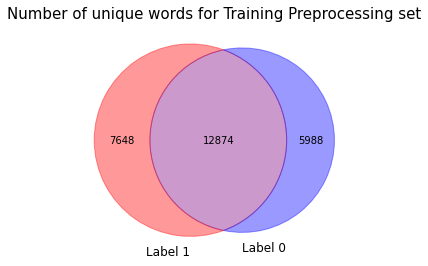

In [40]:
# plot venn diagram on number of unique words for training preprocessed data for each class

# set figure size
fig, ax = plt.subplots(figsize = (5,10))
# set title
ax.set_title('Number of unique words for Training Preprocessing set', fontsize=15)
sets = [set(all_words_up),set(all_words_down)]
# plot venn diafram
v=venn2(sets, set_labels =  ('Label 1', 'Label 0'),ax=ax)

# add color and design
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('blue')
v.get_patch_by_id('01').set_alpha(0.4)
v.get_patch_by_id('11').set_color('purple')
v.get_patch_by_id('11').set_alpha(0.4)

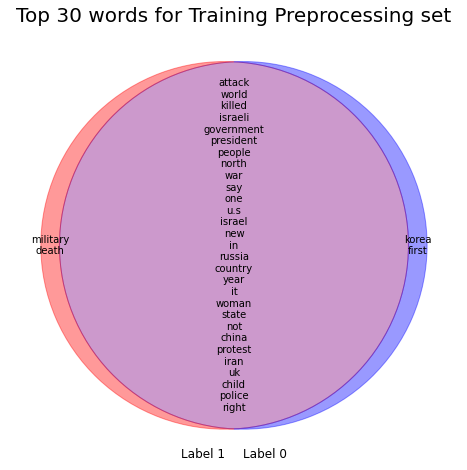

In [41]:
# Display venn diagram top 30 words for training preprocessing data for each class

# select top 30 words for each label
# first 4 is skipped cause its useless words that came from cleaning
A = set(counts_up_df.loc[4:34,'words'])
B = set(counts_down_df.loc[4:34,'words'])
# set figure size
fig, ax = plt.subplots(figsize = (19,8))
# set title
ax.set_title('Top 30 words for Training Preprocessing set', fontsize=20)
# plot venn diafram
v = venn2([A,B], ('Label 1', 'Label 0'),ax=ax)
v.get_label_by_id('10').set_text('\n'.join(B-A))
v.get_label_by_id('11').set_text('\n'.join(A&B))
v.get_label_by_id('01').set_text('\n'.join(A-B))

# add color
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('blue')
v.get_patch_by_id('01').set_alpha(0.4)
v.get_patch_by_id('11').set_color('purple')
v.get_patch_by_id('11').set_alpha(0.4)

In [42]:
# merge into dataframe top 150 words for each label
df_all = pd.merge(counts_up_df,counts_down_df,on='words',how='outer')
df_all.columns=['words','count_up','count_down']
# for those empty in other class replace as 0
df_all.fillna(0,inplace=True)
# display some words in only label 0
df_all.tail()

,words,count_up,count_down
157,public,0.0,200.0
158,many,0.0,200.0
159,weapon,0.0,199.0
160,crisis,0.0,197.0
161,even,0.0,196.0


In [43]:
# looking at the proportion of top 150 words in each other classes
df_all['proportion'] = np.divide(df_all['count_up'], df_all['count_down'], out=np.zeros_like(df_all['count_up']), where=df_all['count_down']!=0)
df_all.sort_values(by='proportion',ascending=True,inplace=True)
df_all[:10]

,words,count_up,count_down,proportion
161,even,0.0,196.0,0.0
131,gay,263.0,0.0,0.0
132,australian,263.0,0.0,0.0
160,crisis,0.0,197.0,0.0
135,troop,262.0,0.0,0.0
138,secret,252.0,0.0,0.0
142,men,249.0,0.0,0.0
143,worker,248.0,0.0,0.0
144,britain,246.0,0.0,0.0
145,rebel,244.0,0.0,0.0


In [44]:
# join the text to calculate the length of words for each label
up_train_text_count = " ".join(post for post in train_df_count['Combined_new'][train_df_count['Label']==1])
down_train_text_count = " ".join(post for post in train_df_count['Combined_new'][train_df_count['Label']==0])

# add 'percentage of total' column
counts_up_df['Percentage of total'] = counts_up_df['count'].map(lambda x: (x/len(up_train_text_count))*100)
counts_down_df['Percentage of total'] = counts_down_df['count'].map(lambda x: (x/len(down_train_text_count))*100)

# display the top 5 'percentage of total' 
counts_up_df.head()

,words,count,Percentage of total
0,s,3881,0.211123
1,the,2319,0.126151
2,u,1308,0.071154
3,a,1164,0.063320
4,israel,1071,0.058261


In [45]:
# display the top 5 'percentage of total' 
counts_down_df.head()

,words,count,Percentage of total
0,s,3270,0.211201
1,the,1916,0.123750
2,u,1180,0.076213
3,a,928,0.059937
4,world,905,0.058452


In [46]:
# Decide to set 0.05% as threshold to add to stopwords after looking at the top 50 most common words for each class
final_stopwords_up = [counts_up_df['words'][i] for i in counts_up_df.index  if counts_up_df['Percentage of total'][i]>0.05]
final_stopwords_down = [counts_down_df['words'][i] for i in counts_down_df.index  if counts_down_df['Percentage of total'][i]>0.05]
print("Selected stopwords for label=1:\n")
print(final_stopwords_up)
print("\nSelected stopwords for label=0:\n")
print(final_stopwords_down)
# decide to remove 'say' and 'year' which seems useless to the stopwords list earlier
# the top 4 words 's', 'the', 'u', 'a' wasn't removed because they appear after lemmatize

Selected stopwords for label=1:

['s', 'the', 'u', 'a', 'israel', 'say', 'year', 'not', 'world', 'china', 'government', 'new']

Selected stopwords for label=0:

['s', 'the', 'u', 'a', 'world', 'year', 'israel', 'say', 'not', 'new', 'government', 'china']


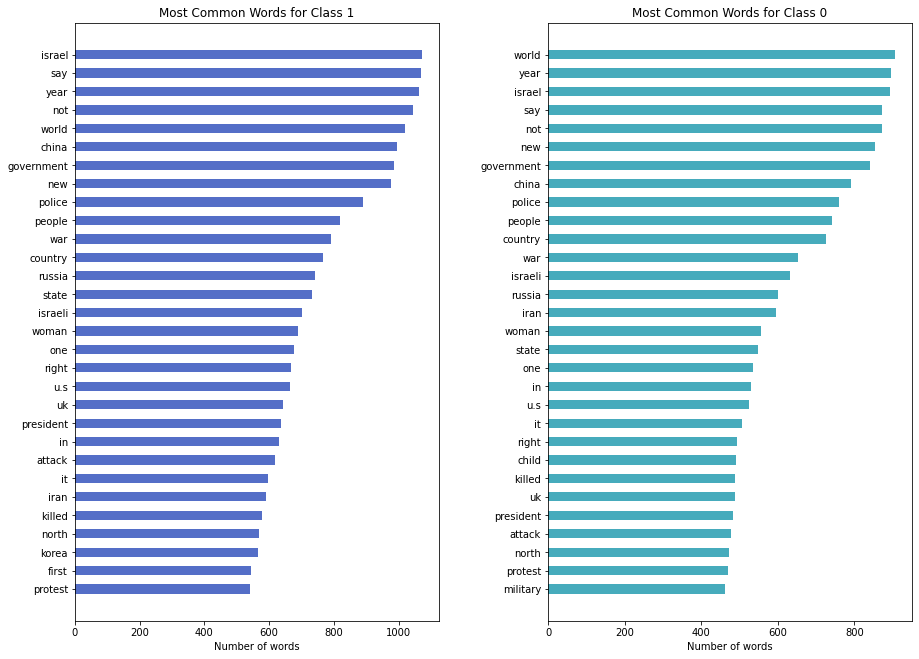

In [47]:
# set figure size
fig, axes = plt.subplots(ncols=2, figsize=(15,11))
plt.subplots_adjust(wspace=.3)

# plot most common words for label 1
axes[0].barh(counts_up_df[4:34].sort_values(by='count',ascending=False)['words'], counts_up_df[4:34].sort_values(by='count',ascending=False)['count'], .5, color='#294AB9', 
             alpha=0.8)
axes[0].invert_yaxis()
axes[0].set_title("Most Common Words for Class 1", 
                  fontsize=12)
axes[0].set_xlabel("Number of words")

# plot most common words for label 0
axes[1].barh(counts_down_df[4:34].sort_values(by='count',ascending=False)['words'], counts_down_df[4:34].sort_values(by='count',ascending=False)['count'], .5, color='#1896ac', 
             alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_title("Most Common Words for Class 0", 
                  fontsize=12)
axes[1].set_xlabel("Number of words");

In [48]:
# Function to get bi gram from preprocessed train set
def get_top_bi_gram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    df = pd.DataFrame()
    df['count'] = [sum_words[0, idx] for word, idx in vec.vocabulary_.items()]
    df['words'] = [word for word, idx in vec.vocabulary_.items()]
    df.sort_values(by='count',ascending=False,inplace=True)
    return df

# Select Top 30 bi gram from preprocessed train set 
bi_gram_up = get_top_bi_gram(price_up['Combined_new'], 30)
bi_gram_down = get_top_bi_gram(price_down['Combined_new'], 30)

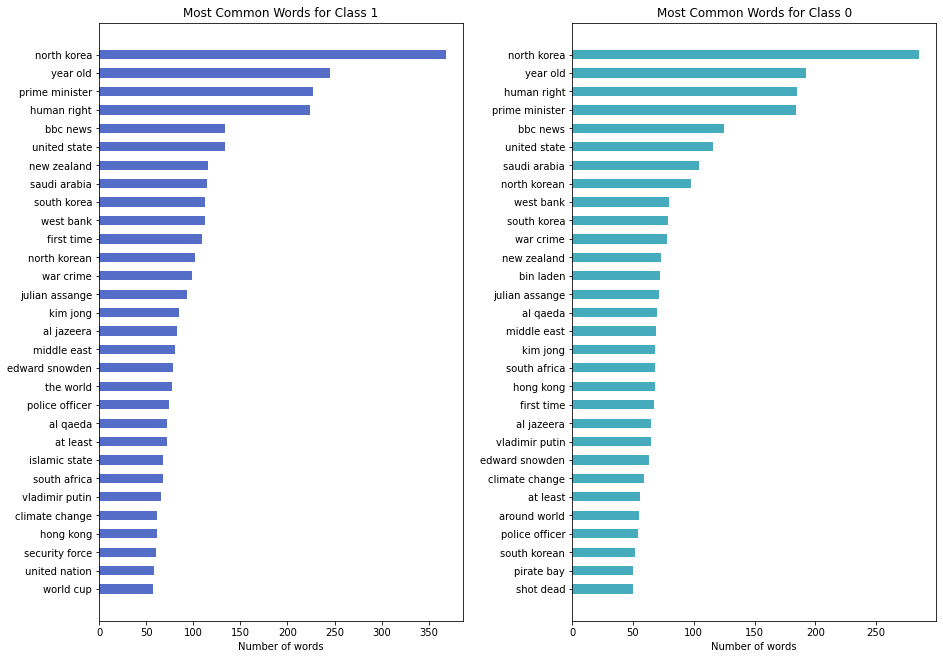

In [49]:
# set figure size
fig, axes = plt.subplots(ncols=2, figsize=(15,11))
plt.subplots_adjust(wspace=.3)

# plot most common bi-gram words for label 1
axes[0].barh(bi_gram_up[:30].sort_values(by='count',ascending=False)['words'], bi_gram_up[:30].sort_values(by='count',ascending=False)['count'], .5, color='#294AB9', 
             alpha=0.8)
axes[0].invert_yaxis()
axes[0].set_title("Most Common Words for Class 1", 
                  fontsize=12)
axes[0].set_xlabel("Number of words")

# plot most common bi-gram words for label 0
axes[1].barh(bi_gram_down[:30].sort_values(by='count',ascending=False)['words'], bi_gram_down[:30].sort_values(by='count',ascending=False)['count'], .5, color='#1896ac', 
             alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_title("Most Common Words for Class 0", 
                  fontsize=12)
axes[1].set_xlabel("Number of words");

In [50]:
# Function to get tri gram from preprocessed train set
def get_top_tri_gram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    df = pd.DataFrame()
    df['count'] = [sum_words[0, idx] for word, idx in vec.vocabulary_.items()]
    df['words'] = [word for word, idx in vec.vocabulary_.items()]
    df.sort_values(by='count',ascending=False,inplace=True)
    return df

# Select Top 30 tri gram from preprocessed train set 
tri_gram_up = get_top_tri_gram(price_up['Combined_new'], 30)
tri_gram_down = get_top_tri_gram(price_down['Combined_new'], 30)

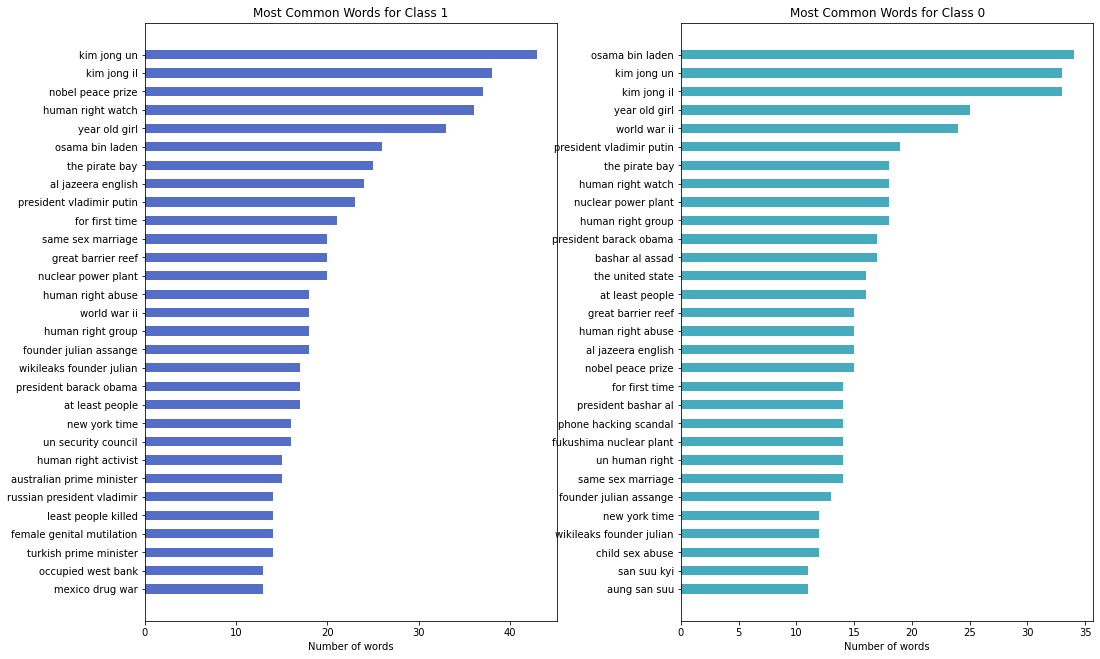

In [51]:
# set figure size
fig, axes = plt.subplots(ncols=2, figsize=(17,11))
plt.subplots_adjust(wspace=.3)

# plot most common tri-gram words for label 1
axes[0].barh(tri_gram_up[:30].sort_values(by='count',ascending=False)['words'], tri_gram_up[:30].sort_values(by='count',ascending=False)['count'], .5, color='#294AB9', 
             alpha=0.8)
axes[0].invert_yaxis()
axes[0].set_title("Most Common Words for Class 1", 
                  fontsize=12)
axes[0].set_xlabel("Number of words")

# plot most common tri-gram words for label 0
axes[1].barh(tri_gram_down[:30].sort_values(by='count',ascending=False)['words'], tri_gram_down[:30].sort_values(by='count',ascending=False)['count'], .5, color='#1896ac', 
             alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_title("Most Common Words for Class 0", 
                  fontsize=12)
axes[1].set_xlabel("Number of words");

# Fit Logistic Model with CountVectorizer 1-gram

In [52]:
log_params = {
    'logreg__C':[1e-6],  #[1e-5,1e-4,1e03,1e-2,1,100,1000,5000]
    'logreg__max_iter':[400], # [350,450,500,800]
    'logreg__penalty' : ['l2'],  #['l1','elasticnet', 'none']
    'cvec_1gram__max_features' : [500] #[600,800,2000]
}

In [53]:
# Instantiate vectorizer and log reg
log_cvec_1_steps = [('cvec_1gram',CountVectorizer()),('logreg', LogisticRegression())]
# Put into Pipeline
log_cvec_1_pipe = Pipeline(log_cvec_1_steps)
# Get parameters
#log_cvec_1_pipe.get_params()
# Instantiate GridsearchcV
log_search = GridSearchCV(log_cvec_1_pipe,log_params,cv=10,verbose=1)

In [54]:
# Fit GridSearchCV with Logistic Regression model with cvec 1-gram
log_search.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', log_search.best_params_)
print('Best CV Train Accuracy score: ', log_search.best_score_)
print('Training Accuracy score:', log_search.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', log_search.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished


Best parameters:  {'cvec_1gram__max_features': 500, 'logreg__C': 1e-06, 'logreg__max_iter': 400, 'logreg__penalty': 'l2'}
Best CV Train Accuracy score:  0.5424253144654088
Training Accuracy score: 0.5424261470773099
Validation Accuracy score: 0.507537688442211
            


# Fit Logistic Model with CountVectorizer 2-gram

In [55]:
log_params_2 = {
    'logreg__C':[1e-6], #[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]
    'logreg__max_iter':[200], #[250,300,400,800,1000]
    'logreg__penalty' : ['l2'], #['l1','elasticnet', 'none']
    'cvec_2gram__max_features' : [500] #[1000,1500,5000]
}

In [56]:
# Instantiate vectorizer and log reg
log_cvec_2_steps = [('cvec_2gram',CountVectorizer(ngram_range=(2,2))),('logreg', LogisticRegression())]
# Put into Pipeline
log_cvec_2_pipe = Pipeline(log_cvec_2_steps)
# Get parameters
#log_cvec_2_pipe.get_params()
# Instantiate GridsearchcV
log_search_2 = GridSearchCV(log_cvec_2_pipe,log_params_2,cv=10,verbose=1)

In [57]:
# Fit GridSearchCV with Logistic Regression model with cvec 2-gram
log_search_2.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', log_search_2.best_params_)
print('Best CV Train Accuracy score: ', log_search_2.best_score_)
print('Training Accuracy score:', log_search_2.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', log_search_2.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Best parameters:  {'cvec_2gram__max_features': 500, 'logreg__C': 1e-06, 'logreg__max_iter': 200, 'logreg__penalty': 'l2'}
Best CV Train Accuracy score:  0.5424253144654088
Training Accuracy score: 0.5424261470773099
Validation Accuracy score: 0.507537688442211
            


# Fit Logistic Model with CountVectorizer 3-gram

In [58]:
log_params_3 = {
    'logreg__C':[0.05], #[1e-4,1e-2,1e-1,0.02,1,100,500]
    'logreg__max_iter':[600], #[400,500,650,800]
    'logreg__penalty' : ['l2'], #['l1', 'elasticnet', 'none']
    'cvec_3gram__max_features' : [700] #[500,600,1000]
}

In [59]:
# Instantiate vectorizer and log reg
log_cvec_3_steps = [('cvec_3gram',CountVectorizer(ngram_range=(3,3))),('logreg', LogisticRegression())]
# Put into Pipeline
log_cvec_3_pipe = Pipeline(log_cvec_3_steps)
# Get parameters
#log_cvec_3_pipe.get_params()
# Instantiate GridsearchcV
log_search_3 = GridSearchCV(log_cvec_3_pipe,log_params_3,cv=10,verbose=1)

In [60]:
# Fit GridSearchCV with Logistic Regression model with cvec 3-gram
log_search_3.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', log_search_3.best_params_)
print('Best CV Train Accuracy score: ', log_search_3.best_score_)
print('Training Accuracy score:', log_search_3.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', log_search_3.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.2s finished


Best parameters:  {'cvec_3gram__max_features': 700, 'logreg__C': 0.05, 'logreg__max_iter': 600, 'logreg__penalty': 'l2'}
Best CV Train Accuracy score:  0.515381289308176
Training Accuracy score: 0.6253928346951603
Validation Accuracy score: 0.5150753768844221
            


# Fit Logistic Model with Tfidf Vectorizer 2-gram

In [61]:
log_params_4 = {
    'logreg__C':[1e-1], # [1e-2,0.09,0.05,1,100]
    'logreg__max_iter':[400], # [450,500,800]
    'logreg__penalty' : ['l2'], #['l1', 'l2', 'elasticnet', 'none']
    'tvec__max_features' : [500] #[450,600,800]
}

In [62]:
# Instantiate vectorizer and log reg
log_tvec_steps = [('tvec',TfidfVectorizer(ngram_range = (2, 2))),('logreg', LogisticRegression())]
# Put into Pipeline
log_tvec_pipe = Pipeline(log_tvec_steps)
# Get parameters
#log_tvec_pipe.get_params()
# Instantiate GridsearchcV
log_search_tvec = GridSearchCV(log_tvec_pipe,log_params_4,cv=10,verbose=1)

In [63]:
# Fit GridSearchCV with Logistic Regression model with tvec
log_search_tvec.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', log_search_tvec.best_params_)
print('Best CV Train Accuracy score: ', log_search_tvec.best_score_)
print('Training Accuracy score:', log_search_tvec.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', log_search_tvec.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.1s finished


Best parameters:  {'logreg__C': 0.1, 'logreg__max_iter': 400, 'logreg__penalty': 'l2', 'tvec__max_features': 500}
Best CV Train Accuracy score:  0.5411674528301887
Training Accuracy score: 0.5669390320553112
Validation Accuracy score: 0.5025125628140703
            


# Fit Random Forest with CountVectorizer 2-gram

In [64]:
rf_param = {
    'rf__n_estimators':[400], #[250,300,350,500,800,1000]
    'rf__max_depth': [1], #[None,2]
    'cvec_2gram__max_features' : [1500] #[500,1000,1700,1800,2000,3000]
}

# Instantiate vectorizer and Random Forest
rf_cvec_2_steps = [('cvec_2gram',CountVectorizer(ngram_range=(2,2))),('rf', RandomForestClassifier())]
# Put into Pipeline
rf_cvec_2_pipe = Pipeline(rf_cvec_2_steps)
# Instantiate GridsearchcV
rf_search_cvec_2 = GridSearchCV(rf_cvec_2_pipe,param_grid=rf_param,cv=10,verbose=1)

In [65]:
# Fit GridSearchCV with Random Forest model with 2gram countvectorizer
rf_search_cvec_2.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', rf_search_cvec_2.best_params_)
print('Best CV Train Accuracy score: ', rf_search_cvec_2.best_score_)
print('Training Accuracy score:', rf_search_cvec_2.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', rf_search_cvec_2.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.6s finished


Best parameters:  {'cvec_2gram__max_features': 1500, 'rf__max_depth': 1, 'rf__n_estimators': 400}
Best CV Train Accuracy score:  0.5424253144654088
Training Accuracy score: 0.5424261470773099
Validation Accuracy score: 0.507537688442211
            


# Fit Random Forest with Tfidf Vectorizer

In [66]:
rf_param = {
    'rf__n_estimators':[250], #[200,300,350,400,500]
    'rf__max_depth': [2], #[None,1]
    'tvec__max_features' : [1500] #[500,1000,1800,2000,5000]
}

# Instantiate vectorizer and Random Forest
rf_tvec_steps = [('tvec', TfidfVectorizer()),('rf', RandomForestClassifier())]
# Put into Pipeline
rf_tvec_pipe = Pipeline(rf_tvec_steps)
# Instantiate GridsearchcV
rf_search_tvec = GridSearchCV(rf_tvec_pipe,param_grid=rf_param,cv=10,verbose=1)

In [67]:
# Fit GridSearchCV with Random Forest model with tvec
rf_search_tvec.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', rf_search_tvec.best_params_)
print('Best CV Train Accuracy score: ', rf_search_tvec.best_score_)
print('Training Accuracy score:', rf_search_tvec.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', rf_search_tvec.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.8s finished


Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 250, 'tvec__max_features': 1500}
Best CV Train Accuracy score:  0.5424253144654088
Training Accuracy score: 0.5430546825895664
Validation Accuracy score: 0.507537688442211
            


# Fit Naive Bayes with CountVectorizer 2-gram

In [68]:
nb_param = {
    'nb__alpha':[100], #[1e-5,1e-3,1,50,150,200,500,1000]
    'cvec_2gram__max_features' : [1000] #[500,800,900,950,1100,1200,1700,1500]
}

# Instantiate vectorizer and Naive Bayes
nb_cvec_2_steps = [('cvec_2gram',CountVectorizer(ngram_range=(2,2))),('nb', MultinomialNB())]
# Put into Pipeline
nb_cvec_2_pipe = Pipeline(nb_cvec_2_steps)
# Instantiate GridsearchcV
nb_search_cvec_2 = GridSearchCV(nb_cvec_2_pipe,param_grid=nb_param,cv=10,verbose=1)

In [69]:
# Fit GridSearchCV with Naive bayes model with bigram countvectorizer
nb_search_cvec_2.fit(X_train['Combined_new'],y_train)
print('Best parameters: ', nb_search_cvec_2.best_params_)
print('Best CV Train Accuracy score: ', nb_search_cvec_2.best_score_)
print('Training Accuracy score:', nb_search_cvec_2.score(X_train['Combined_new'], y_train))
print('Validation Accuracy score:', nb_search_cvec_2.score(X_test['Combined_new'], y_test))
print('            ')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


Best parameters:  {'cvec_2gram__max_features': 1000, 'nb__alpha': 100}
Best CV Train Accuracy score:  0.545558176100629
Training Accuracy score: 0.6216216216216216
Validation Accuracy score: 0.5050251256281407
            


# Sentimental Score Feature Engineering

Since using the text alone parsing through vectorizer doesn't predict well, let's try the Python module ‘Textblob’ which gives the sentiment of each sentence and giving it a score between -1 and 1.

In [70]:
# Read csv
data = pd.read_csv('./datasets/Combined_News_DJIA.csv')
data.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."


In [71]:
# melt data to get sentiment score later
sa_df = pd.melt(data, id_vars=['Date','Label'])
sa_df = sa_df.sort_values(by=['Date'])
sa_df.head()

,Date,Label,variable,value
0,2008-08-08,0,Top1,"b""Georgia 'downs two Russian warplanes' as cou..."
37791,2008-08-08,0,Top20,"b""Georgia will withdraw 1,000 soldiers from Ir..."
23868,2008-08-08,0,Top13,"b""So---Russia and Georgia are at war and the N..."
25857,2008-08-08,0,Top14,"b""China tells Bush to stay out of other countr..."
35802,2008-08-08,0,Top19,b'This is a busy day: The European Union has ...


In [72]:
# Train Test Split
train = sa_df[sa_df['Date'] < '2014-12-03']
test = sa_df[sa_df['Date'] > '2014-12-04']

In [73]:
# Display top 5 train data
train.head()

,Date,Label,variable,value
0,2008-08-08,0,Top1,"b""Georgia 'downs two Russian warplanes' as cou..."
37791,2008-08-08,0,Top20,"b""Georgia will withdraw 1,000 soldiers from Ir..."
23868,2008-08-08,0,Top13,"b""So---Russia and Georgia are at war and the N..."
25857,2008-08-08,0,Top14,"b""China tells Bush to stay out of other countr..."
35802,2008-08-08,0,Top19,b'This is a busy day: The European Union has ...


In [74]:
# Function for basic cleanup without lemmatize

def basic_cleanup(titles):
    # Function to convert a raw titles to a string of words
    # The input is a single string (a raw title of a news), and 
    # the output is a single string (a preprocessed title)
    
    # 1. Remove HTML, if any
    titles = BeautifulSoup(titles).get_text()

     # 2. Remove b' starting
    titles = re.sub('(^b\')|(^b\")',' ',''.join(titles))

    # 3. Remove non-letters and non-numbers except full stop
    # A-z didn't remove \ properly so used A-Za-z instead
    titles = ''.join(re.sub("[^0-9A-Za-z. \t]",' ', titles))

    # 4. Convert to lower case, split into individual words
    titles = titles.lower()
    
    # 5. Tokenize: Split the sentence into words
    words_list = nltk.word_tokenize(titles)
    
    # 6. Remove full stop only
    # Convert example U.S. to U.S 
    cleaned_titles = re.sub('\.\s+',' ',' '.join(words_list))
    cleaned_titles = re.sub('\s+\.',' ',''.join(cleaned_titles))
    
    return (cleaned_titles)

In [75]:
# Apply basic cleanup function to train and test data
train['cleaned'] =train['value'].apply(lambda x: basic_cleanup(str(x)))
test['cleaned'] =test['value'].apply(lambda x: basic_cleanup(str(x)))

/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
# Display cleaned train and test
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 200)
train.head()

,Date,Label,variable,value,cleaned
0,2008-08-08,0,Top1,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",georgia downs two russian warplanes as countries move to brink of war
37791,2008-08-08,0,Top20,"b""Georgia will withdraw 1,000 soldiers from Iraq to help fight off Russian forces in Georgia's breakaway region of South Ossetia""",georgia will withdraw 1 000 soldiers from iraq to help fight off russian forces in georgia s breakaway region of south ossetia
23868,2008-08-08,0,Top13,"b""So---Russia and Georgia are at war and the NYT's top story is opening ceremonies of the Olympics? What a fucking disgrace and yet further proof of the decline of journalism.""",so russia and georgia are at war and the nyt s top story is opening ceremonies of the olympics what a fucking disgrace and yet further proof of the decline of journalism
25857,2008-08-08,0,Top14,"b""China tells Bush to stay out of other countries' affairs""",china tells bush to stay out of other countries affairs
35802,2008-08-08,0,Top19,b'This is a busy day: The European Union has approved new sanctions against Iran in protest at its nuclear programme.',this is a busy day the european union has approved new sanctions against iran in protest at its nuclear programme


In [77]:
test.head()

,Date,Label,variable,value,cleaned
3582,2014-12-05,1,Top2,Dozens of Chinese held in Kenya accused of preparing to raid the country's communications systems,dozens of chinese held in kenya accused of preparing to raid the country s communications systems
7560,2014-12-05,1,Top4,"Blame your boss, not China, for stagnant wage growth: ILO",blame your boss not china for stagnant wage growth ilo
27450,2014-12-05,1,Top14,Land Mines Arent Killing As Many People As They Used To,land mines arent killing as many people as they used to
17505,2014-12-05,1,Top9,Snowden docs show NSA spied on global cellphone networks,snowden docs show nsa spied on global cellphone networks
23472,2014-12-05,1,Top12,"Turkish President Recep Tayyip Erdogan on Thursday condemned the United Nations Security Council for being an unrepresentative ""Christian body,"" as well as the ""biased"" decisions of Norway's Nobel...",turkish president recep tayyip erdogan on thursday condemned the united nations security council for being an unrepresentative christian body as well as the biased decisions of norway s nobel priz...


In [78]:
# Apply function to get sentiment score for train and test data
train["Sentiment_score"] = train['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
test["Sentiment_score"] = test['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Tried with no cleanup. doesnt seems to affect score

/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
# Function to return convert sentiment score to 3 labels: positive, neutral or negative 
def sentiment(titles):
    analysis = TextBlob(titles)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity ==0:
        return 'Neutral'
    else:
        return 'Negative'

In [80]:
# Apply function to get sentiment class for train and test data
train["Sentiment"] = train['cleaned'].apply(lambda x: sentiment(x))
test["Sentiment"] = test['cleaned'].apply(lambda x: sentiment(x))

/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
# Display train set to check 
train.head()

,Date,Label,variable,value,cleaned,Sentiment_score,Sentiment
0,2008-08-08,0,Top1,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",georgia downs two russian warplanes as countries move to brink of war,0.000000,Neutral
37791,2008-08-08,0,Top20,"b""Georgia will withdraw 1,000 soldiers from Iraq to help fight off Russian forces in Georgia's breakaway region of South Ossetia""",georgia will withdraw 1 000 soldiers from iraq to help fight off russian forces in georgia s breakaway region of south ossetia,0.000000,Neutral
23868,2008-08-08,0,Top13,"b""So---Russia and Georgia are at war and the NYT's top story is opening ceremonies of the Olympics? What a fucking disgrace and yet further proof of the decline of journalism.""",so russia and georgia are at war and the nyt s top story is opening ceremonies of the olympics what a fucking disgrace and yet further proof of the decline of journalism,-0.033333,Negative
25857,2008-08-08,0,Top14,"b""China tells Bush to stay out of other countries' affairs""",china tells bush to stay out of other countries affairs,-0.125000,Negative
35802,2008-08-08,0,Top19,b'This is a busy day: The European Union has approved new sanctions against Iran in protest at its nuclear programme.',this is a busy day the european union has approved new sanctions against iran in protest at its nuclear programme,0.078788,Positive


# Fit Logistic Regression for the Sentiment Score

In [82]:
log_params = {
    'logreg__C':[1e-6], #[0.000055,1e-5,1e-4,1e-2,1,10,100,1000,5000]
    'logreg__max_iter':[200], #[100,150,250,400,500,800,1000,2000]
    'logreg__penalty' : ['l2'], #['l1','elasticnet', 'none']
}

In [83]:
# Instantiate vectorizer and log reg
log_steps = [('logreg', LogisticRegression())]
# Put into Pipeline
log_pipe = Pipeline(log_steps)
# Get parameters
#log_pipe.get_params()
# Instantiate GridsearchcV
log_search = GridSearchCV(log_pipe,log_params,cv=10,verbose=1)

In [84]:
test['Sentiment_score'].head()

3582     0.0
7560     0.0
27450    0.5
17505    0.0
23472    0.0
Name: Sentiment_score, dtype: float64

In [85]:
# Fit GridSearchCV with Logistic Regression model 
# 39775 obs for training
log_search.fit(np.array(train['Sentiment_score']).reshape(-1, 1),train['Label'])
print('Best parameters: ', log_search.best_params_)
print('Best CV Train Accuracy score: ', log_search.best_score_)
print('Training Accuracy score:', log_search.score(np.array(train['Sentiment_score']).reshape(-1, 1),train['Label']))
print('Validation Accuracy score:', log_search.score(np.array(test['Sentiment_score']).reshape(-1, 1),test['Label']))
print('            ')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters:  {'logreg__C': 1e-06, 'logreg__max_iter': 200, 'logreg__penalty': 'l2'}
Best CV Train Accuracy score:  0.5424261398466017
Training Accuracy score: 0.5424261470773099
Validation Accuracy score: 0.5075757575757576
            


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [102]:
# Groupby Date
#train.groupby('Date')['Sentiment_score'].mean()

# Best Model: Logistic Regression with CountVectorizer 3-gram

Though still worse than baseline, let's still take a look

In [87]:
# Instantiate vectorizer and log reg
log_cvec_3_steps = [('cvec_3gram',CountVectorizer(ngram_range=(3,3),max_features=700)),('logreg', LogisticRegression(C=0.05,max_iter=600,penalty='l2'))]
# Put into Pipeline
log_cvec_3_pipe = Pipeline(log_cvec_3_steps)

In [88]:
# Fit GridSearchCV with Logistic Regression model with cvec 3-gram
log_cvec_3_pipe.fit(X_train['Combined_new'],y_train)
#print('Training Accuracy score:', log_cvec_3_pipe.score(X_train['Combined_new'], y_train))
#print('Validation Accuracy score:', log_cvec_3_pipe.score(X_test['Combined_new'], y_test))
#print('            ')

Pipeline(memory=None,
         steps=[('cvec_3gram',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=700, min_df=1, ngram_range=(3, 3),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=0.05, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=600,
                                    multi_class='auto', n_jobs=None,
                 

In [89]:
print('Best CV Train Accuracy score: ', cross_val_score(log_cvec_3_pipe,X_train['Combined_new'],y_train,cv=10).mean())

Best CV Train Accuracy score:  0.515381289308176


In [90]:
# Score our model on the testing set
# This is Accuracy score 
print(f"The best test score is: {round(log_cvec_3_pipe.score(X_test['Combined_new'], y_test),3)*100} %")

The best test score is: 51.5 %


\begin{eqnarray*}
\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\Rightarrow \frac{P(Y=1)}{1-P(Y=1)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\end{eqnarray*}

In [91]:
log_coef = log_cvec_3_pipe.named_steps['logreg'].coef_
cvec_cols = log_cvec_3_pipe.named_steps['cvec_3gram'].get_feature_names()

In [92]:
# keep the coefficients in dataframe
coefficients = pd.concat([pd.DataFrame(cvec_cols),pd.DataFrame(np.transpose(log_coef))], axis = 1)
coefficients.columns=['word','coef']
coefficients['exp_coef'] = coefficients['coef'].map(lambda x: math.exp(x))
coefficients.sort_values(by='coef',ascending=False).head(10)

,word,coef,exp_coef
370,nobel peace prize,0.227356,1.255276
643,un security council,0.179091,1.196129
234,human right watch,0.175956,1.192386
366,no fly zone,0.146013,1.157211
441,president evo morale,0.142998,1.153728
471,pro russian separatist,0.131392,1.140415
63,bolivian president evo,0.129902,1.138717
19,alleged war crime,0.121635,1.129342
627,turkey prime minister,0.120127,1.127640
89,cia drone strike,0.119672,1.127127


In [93]:
coefficients.sort_values(by='coef',ascending=True).head(10)

,word,coef,exp_coef
423,phone hacking scandal,-0.209783,0.810760
146,first country world,-0.170974,0.842843
137,face year jail,-0.164724,0.848128
570,syrian security force,-0.155513,0.855976
685,world war ii,-0.147784,0.862617
348,nato air strike,-0.144992,0.865030
248,iran nuclear facility,-0.139876,0.869466
289,last year the,-0.127778,0.880049
490,rio de janeiro,-0.126497,0.881176
186,genetically modified crop,-0.126275,0.881373


In [94]:
# Function to plot ROC curve with AUC
def plot_roc(model, X, actual_y, title):
    
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X)
    preds = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(actual_y, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7,5))
    plt.title(title +': ROC Curve with AUC = ' + '%0.2f' % roc_auc, fontsize=12, fontweight='bold')
    plt.plot(fpr, tpr, 'b', label='ROC Curve') # Plot the ROC curve
    plt.plot([0, 1], [0, 1],'r--', label='Baseline') # Plot baseline 
    plt.legend(loc = 'lower right')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('Sensitivity:True Positive Rate')
    plt.xlabel('1-Specificity:False Positive Rate');

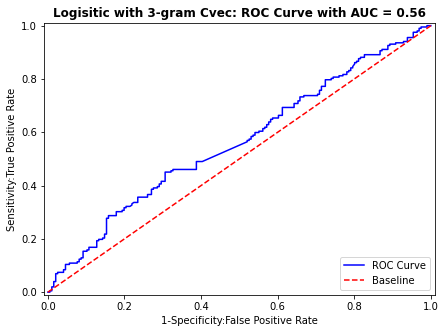

In [95]:
# Plot the ROC curve
plot_roc(model = log_cvec_3_pipe, 
         X = X_test['Combined_new'],
         actual_y = y_test,
         title = "Logisitic with 3-gram Cvec")

In [96]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, log_cvec_3_pipe.predict(X_test['Combined_new'])).ravel()

In [97]:
pd.Series(log_cvec_3_pipe.predict(X_test['Combined_new'])).value_counts(normalize=True)

1    0.927136
0    0.072864
dtype: float64

In [98]:
y_test.value_counts(normalize=True)

1    0.507538
0    0.492462
Name: Label, dtype: float64

In [99]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 16
False Positives: 180
False Negatives: 13
True Positives: 189


In [100]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

# only keen on positive outcome so use only positive column
pred_proba = [i[1] for i in log_cvec_3_pipe.predict_proba(X_test['Combined_new'])]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

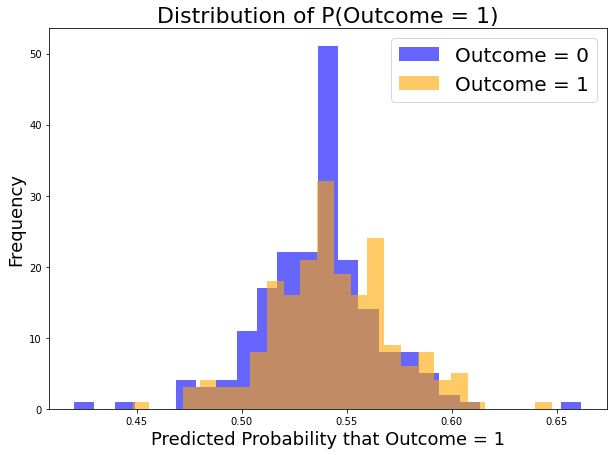

In [101]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Conclusion

Using top 25 world news title from reddit alone may not be a sufficient corpus to train a good model for predicting whether price will go up or down for DJIA. The test score is worse than the baseline model(score:0.5424) despite running a few models and vectorizers. The best model, though below baseline model, was using 3 ngram CountVectorizer with Logisitic Regression with validation accuracy score of 0.5150. Best training Accuracy score during GridSearch was 0.6253. However, cross validation mean score is 0.5153. Overall there is still underfit since validation score is not better than baseline and training score.

Sentimental Analysis using TextBlob was then used to give sentiment scores to the news to model instead of relying on just vectorizing tools from Natural Language Processing. However, the score was still poor below baseline model. Looking into the sentimental score EDA suggest many were give neutral sentiment of score 0, unable to facilitate in modeling.

Though the classification model was not successful, a glimpse into the EDA suggests that everyday news might have little to contribute to the DJIA pricing movement. Hence, this project concludes that watching daily everyday news alone might not be sufficient to decide whether prices are trending upwards or downwards at any given day. Thus, more precaution and work have to be done while trading in stock market. One should not simply trade based on watching daily world news.

"There is nothing wrong with a 'know nothing' investor who realizes it. The problem is when you are a 'know nothing' investor but you think you know something." --Warren Buffett

# Limitations and Recommendation

- Taking a larger corpus such as full news articles instead of titles, longer period of time, more sources
- Adapting 'syuzhet' R package to give a wide range of emotions in addition to sentiments to feed into modeling: eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive)
- Using S&P500 or other larger index comprises of more stocks which may give better prediction result since it may be more representative to the price movement of investors reaction to news